# References

* http://leon.bottou.org/publications/pdf/compstat-2010.pdf
* http://research.microsoft.com/pubs/192769/tricks-2012.pdf
* http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1257413&tag=1
* http://www.sciencedirect.com/science/article/pii/S0305048301000263

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information deap, matplotlib, numpy, pandas, pymc3, seaborn, sklearn, theano

Software,Version
Python,3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,4.1.2
OS,Linux 3.13.0 86 generic x86_64 with debian jessie sid
deap,1.0
matplotlib,1.5.1
numpy,1.10.4
pandas,0.18.0
pymc3,3.0
seaborn,0.7.0
sklearn,0.17.1


In [2]:
from nsga2 import *
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing as preproc
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae
import theano
from theano import tensor as T

#pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)
sns.set()

In [3]:
path = '../btc-data/BTC_LOB_features_10s.csv'
data = pd.read_csv(path, index_col = 0, parse_dates = True)

In [4]:
X, y = data, data['mid price'].copy()

for df in X.columns.tolist():
    X[df] = preproc.StandardScaler().fit(X[df].reshape(-1,1)).transform(X[df].reshape(-1,1))
    
train_dates = X.index[:int(0.7*len(X))]
valid_dates = X.index[int(0.7*len(X)):int(0.85*len(X))]
test_dates = X.index[int(0.85*len(X)):]

In [5]:
X_train = pd.DataFrame()
y_train = y[train_dates[2] : train_dates[-1]]

for i in range(2):
    colname = 'mid price ' + str(i + 1)
    X_train[colname] = X['mid price'].ix[i : (len(train_dates) + i - 2)].values
    
for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
    X_train[c] = X[c].ix[1 : len(train_dates) - 1].values
    
X_train.set_index(train_dates[2:], inplace = True)

In [6]:
X_valid = pd.DataFrame()
y_valid = y[valid_dates[2] : valid_dates[-1]]

for i in range(2):
    colname = 'mid price ' + str(i + 1)
    X_valid[colname] = X['mid price'].ix[(i + len(train_dates)) : (len(train_dates) + len(valid_dates) + i - 2)].values
    
for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
    X_valid[c] = X[c].ix[len(train_dates) + 1 : len(train_dates) + len(valid_dates) - 1].values
    
X_valid.set_index(valid_dates[2:], inplace = True)

In [7]:
X_test = pd.DataFrame()
y_test = y[test_dates[2] : test_dates[-1]]

for i in range(2):
    colname = 'mid price ' + str(i + 1)
    X_test[colname] = X['mid price'].ix[(i + len(train_dates) + len(valid_dates)) : (len(train_dates) + len(valid_dates) + len(test_dates) + i - 2)].values
    
for c in ['ask price', 'bid price', 'mean ask price', 'mean bid price']:
    X_test[c] = X[c].ix[len(train_dates) + len(valid_dates) + 1 : len(train_dates) + len(test_dates) + len(valid_dates) - 1].values
    
X_test.set_index(test_dates[2:], inplace = True)

In [85]:
#def filter_features(mask):
#    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun(model):
    method, indiv = model

    # Train the learner on the training data
    # and evaluate the performance by the test data
    
    if indiv[0] <= 0:
        indiv[0] = 0.002
    
    method.eta0 = indiv[0]
    method.fit(X_train[int(0.25*len(X_train)):], y_train[int(0.25*len(y_train)):])
    
    X_valid25 = X_valid[:int(0.2*len(X_valid))]
    y_valid25 = y_valid[:int(0.2*len(y_valid))]
    
    pred = method.predict(X_valid25)
    rmse = np.sqrt(mse(y_valid25, pred))
    
    act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_valid25.values, y_valid25.values[1:])))
    pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
    act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    dir_sym = np.sum(act_pred_cmp) / len(act_ticks)
    
    return dir_sym, rmse

def nsga2_feat_sel(method, gen_num, indiv_num):
    creator.create("FitnessMulti", base.Fitness, weights = (1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti) 
    toolb.register('eta0', random.uniform, 0.002, 0.01)
    toolb.register('individual', tools.initRepeat, creator.Individual, toolb.eta0, n = 1)
    toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
    toolb.register('evaluate', fitness_fun)
    toolb.register('mate', tools.cxUniform, indpb = 0.1)
    toolb.register('mutate', tools.mutGaussian, mu = 0.002, sigma = 0.001, indpb = 0.1)
    toolb.register('select', tools.selNSGA2)

    population = toolb.population()
    fits = map (toolb.evaluate, map(lambda x: (method, x), population))

    hof = tools.HallOfFame(1)

    for fit, ind in zip(fits, population):
        ind.fitness.values = fit

    best = np.ndarray((gen_num, 2))
    top_RMSE = []

    for gen in range(gen_num):
        offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.55, mutpb = 0.15)
        hof.update(offspring)

        fits = map (toolb.evaluate, map(lambda x: (method, x), offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolb.select(offspring + population, k = indiv_num)

        best[gen] = (hof[0].fitness.values)
        top_RMSE = hof[0]

    chromosome = hof[0]
    #selected_features = list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:]))))
    
    return best, chromosome

Scores [[ 0.60480683  0.59099336]
 [ 0.60480683  0.59099336]
 [ 0.60490246  0.6058137 ]
 [ 0.60490246  0.6058137 ]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61102257  0.71208215]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]
 [ 0.61130945  0.70713209]] 

Chromosome:  [0.010883266130110503] 




<function __main__.feature_selection>

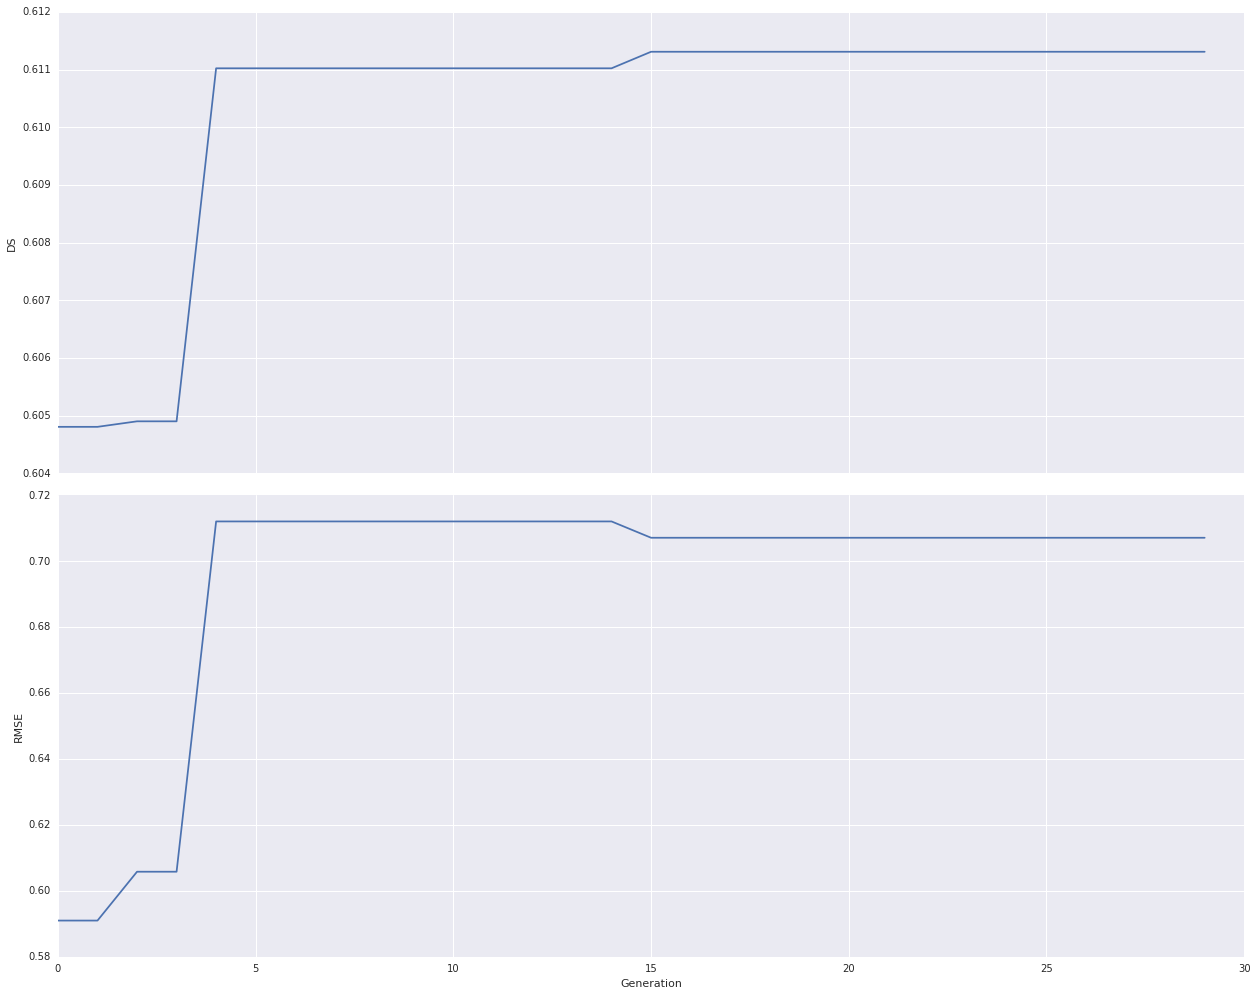

In [87]:
def feature_selection(gen_num, indiv_num):
    
    sgd = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none',
                                    learning_rate = 'constant', epsilon = 0.0, shuffle = False)

    results = nsga2_feat_sel(sgd, gen_num, indiv_num)

    print ('Scores', results[0], '\n')
    print ('Chromosome: ', results[1], '\n\n')
    
    # Create dataframes from the metrics
    results_df = pd.DataFrame(results[0], columns = ['DS', 'RMSE'])
    results_df.insert(0, 'Generation', results_df.index)
    
    # Plot the best individuals of each generation based on the metrics
    g = sns.PairGrid(results_df, y_vars=['DS', 'RMSE'], x_vars = 'Generation', size=7, aspect = 2.5)
    g.map(plt.plot)
    
widgets.interact(feature_selection,  
                 gen_num = 30, 
                 indiv_num = 15)

In [ ]:
clf = svm.LinearSVR(C = 500, loss='epsilon_insensitive', max_iter = 50)
clf.fit(X_train, y_train)

In [ ]:
pred = clf.predict(X_test)
act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
accuracy = np.sum(act_pred_cmp) / len(act_ticks)
accuracy

In [ ]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

In [81]:
clf = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='none',
                                epsilon=0, learning_rate = 'constant', shuffle = False, eta0 = 0.011268947838531019)
clf.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0,
       eta0=0.011268947838531019, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='epsilon_insensitive', n_iter=5,
       penalty='none', power_t=0.25, random_state=None, shuffle=False,
       verbose=0, warm_start=False)

In [82]:
pred = clf.predict(X_test)
act_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(y_test.values, y_test.values[1:])))
pred_ticks = list(map(lambda t: 1 if t[1] - t[0] >= 0 else -1, zip(pred, pred[1:])))
act_pred_cmp = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
accuracy = np.sum(act_pred_cmp) / len(act_ticks)
accuracy

0.6218070084848949

In [83]:
R2 = clf.score(X_test, y_test)
R2
rmse_test = np.sqrt(mse(y_test, pred))
rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))

print(rmse_test)
print(rmse_train)

3.60183496423
2.9402754158


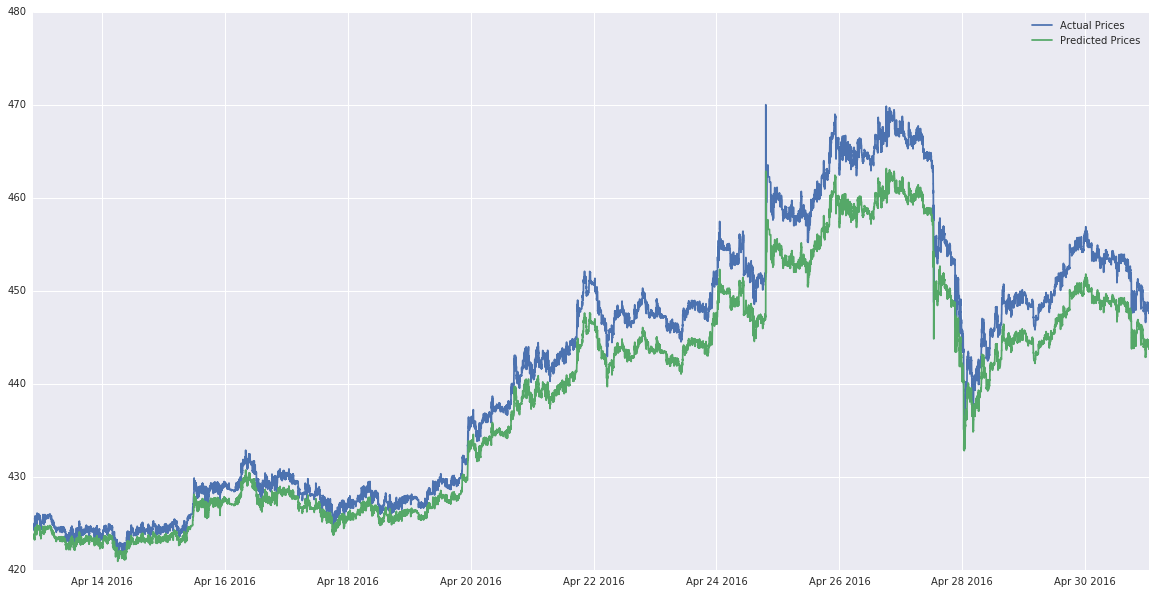

In [84]:
plt.figure(figsize = (20,10))
plt.plot(y_test.index, y_test, label = 'Actual Prices')
plt.plot(y_test.index, pred, label = 'Predicted Prices')
#plt.xlim('2016-04-24 19', '2016-04-24 21')
#plt.ylim(445, 480)
plt.legend()